In [64]:
import pandas as pd
import numpy as np
import random

from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.core.problem import Problem
from pymoo.optimize import minimize

Nova funçao ? Sendo $[x_1, x_2, x_3]$ os atributos de um banco de dados e $[a_1, a_2, ... a_i]$ os pesos a serem estimados  
em que i é o número de atributos ao quadrado temos que: 

$g = (x_1 * a_1 + x_2* a_2 + x_3* a_3)^1 + (x_1 * a_4 + x_2* a_5 + x_3* a_6)^2 + (x_1 * a_7 + x_2* a_8 + x_3* a_9)^3$

In [65]:
def generate_instance(row, w):
    new_instance = sum(row*w)
    return new_instance

def generate_feature(individual, database):
    new_feature = [generate_instance(instance, individual) for instance in database]
    return new_feature


In [66]:
def load_happy_detector():
    label_encoder = preprocessing.LabelEncoder()

    df = pd.read_csv('happy_unhappy.csv')
    df = df.dropna()

    # The data is already normalized

    # cat = df.select_dtypes(exclude=['number'])
    # for col in cat.columns:
    #     df[col] = label_encoder.fit_transform(df[col])

    df = df.to_numpy()
    target = df[:, 6]
    data = df[:, 0:-1]

    dataset = {'target': target,
               'data': data,
               'info': 'https://www.kaggle.com/datasets/priyanshusethi/happiness-classification-dataset',
               'date_access': '2023-10-29'}

    return dataset

In [67]:
def fitness_function(individual, dataset, target, max_depth=1):
    
    new_feature = generate_feature(individual, dataset)
    #MLP no lugar do generate_feature
    decision_tree = tree.DecisionTreeClassifier(max_depth=max_depth)
    decision_tree = decision_tree.fit(np.array(new_feature).reshape(-1,1), target)
    
    leaf_indices = [i for i in range(decision_tree.tree_.node_count) if decision_tree.tree_.children_left[i] == decision_tree.tree_.children_right[i]]
    gini_index = sum(decision_tree.tree_.impurity[leaf_indices]) / len(leaf_indices)
    
    return gini_index

In [68]:
# Initialize population
def initialize_population(population_size, individual_size, lower_bound, upper_bound):
    population = []
    for _ in range(population_size):
        individual = [random.randint(lower_bound, upper_bound) for _ in range(individual_size)]
        population.append(individual)
    return population

In [69]:
df = load_happy_detector()
display(df)

{'target': array([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1,
        0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
        1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
        0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
        1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0], dtype=int64),
 'data': array([[3, 3, 3, 4, 2, 4],
        [3, 2, 3, 5, 4, 3],
        [5, 3, 3, 3, 3, 5],
        [5, 4, 3, 3, 3, 5],
        [5, 4, 3, 3, 3, 5],
        [5, 5, 3, 5, 5, 5],
        [3, 1, 2, 2, 1, 3],
        [5, 4, 4, 4, 4, 5],
        [4, 1, 4, 4, 4, 4],
        [4, 4, 4, 2, 5, 5],
        [3, 2, 3, 3, 2, 3],
        [4, 4, 3, 4, 4, 4],
        [5, 2, 4, 5, 5, 5],
        [4, 2, 4, 5, 4, 3],
        [4, 1, 3, 3, 4, 3],
        [3, 2, 4, 3, 4, 4],
        [5, 3, 4, 5, 4, 5],
      

In [70]:
population_size = len(df['data'])
individual_size = len(df['data'][0])
lower_bound = -10
upper_bound = 10
generations = 100
tournament_size = 20
mutation_rate = 0.1

# Implementação PyMoo

`Separar teste e treino`
`Escolher uma base de dados maior`
`Nova função de generate_feature`

In [71]:
from pymoo.core.problem import Problem

In [72]:
class GiniProblem(Problem):
    def __init__(self, dataset):
        super().__init__(n_var=len(dataset['data'][0]),
                         n_obj=1,
                         n_constr=0,
                         xl=lower_bound,
                         xu=upper_bound)
        self.dataset = dataset

    def _evaluate(self, individuals, out, *args, **kwargs):
        # [print(individual) for individual in individuals]
        out["F"] = np.array([fitness_function(individual, self.dataset['data'], self.dataset['target']) for individual in individuals])


In [73]:
from pymoo.operators.sampling.rnd import IntegerRandomSampling


algorithm = GA(pop_size=population_size,
                             sampling=IntegerRandomSampling(),
                             eliminate_duplicates=True)

problem = GiniProblem(df)

res = minimize(problem,
               algorithm,
               ('n_gen', generations),
               verbose=True)

best_individual = res.X
best_fitness = res.F
print(f"\nBest Individual Overall: {best_individual}, Fitness: {best_fitness}")


[ 8  5 -3  0  7 -5]
[ 8  8 -3 -1 -8 -9]
[ 5  7  4 -2 -2  6]
[  7  -5  10  -8 -10   6]
[-10   7   0   0  -5 -10]
[  9 -10   2   3   4   1]
[ 7  8 -6 -8 -1  8]
[-1 -8 -7 -8 -4 -7]
[ 0 -4 -7  3  6  5]
[-4  8 -3 -9 -8 -7]
[ 9  6  0  2 -2 10]
[ 3 -3  5  6 -3 -1]
[-7  0  5 -9 -6  3]
[ 9 -7  4  7  8 -5]
[  2  10  -5   3 -10   9]
[  6 -10   4  -9 -10  -4]
[ 5  3  4 -3  6 -4]
[-6  6 -7 -8 -5 -1]
[10  8 -2  6 -7  4]
[ 3  1 -4  8 -6 -7]
[  2 -10   5   5   4  -5]
[ 1 -4 -1 10 -8  6]
[-8  3 -6  0 -1  7]
[ 4  3 -4  7 -9 -4]
[  1   8   0 -10   5 -10]
[ 4  8  7  5 -9 -3]
[  6   6 -10   7   0  -7]
[ -8  -6   3   0 -10   4]
[ 3 -9 -9 -5 -9  9]
[ -6 -10   0   8  -1   1]
[-9  0 -7  2  1  1]
[ 2 -7 -2  9 -7 -2]
[-10  -6  -2   7  -9  10]
[-8 -2 -1 -2 10  8]
[-4 -5 -5  5  8  6]
[ 5  4  2  1 10 -6]
[ 7  5 -2  3  6  6]
[ 1  5 -3 -1 10 -8]
[ 5  2  9 -6 -8  7]
[ -3  -6   1 -10   6  -2]
[-9  1 10 -4 -2  0]
[ 6 -1 -5  7  0  1]
[ 9  5 -2  2  2 -8]
[ 5  5  2  9  3 -3]
[-10  -7  10  -2  10   0]
[ 0  2  5 -8  0 -9]
[ 

# Árvore de decisão

In [74]:
df = load_happy_detector()
df_new = load_happy_detector()

aux = pd.DataFrame(df_new['data'])
new_feature = generate_feature(best_individual, df_new['data'])

aux['new_feature'] = new_feature
aux = aux.to_numpy()

df_new['data'] = aux


## Teste sem new_feature

In [75]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['data'], df['target'], test_size=0.2, random_state=42)

decision_tree = tree.DecisionTreeClassifier(max_depth=5)
decision_tree.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=5)

In [76]:
accuracy1 = decision_tree.score(X_test, y_test)
print("Accuracy:", accuracy1)

Accuracy: 0.5862068965517241


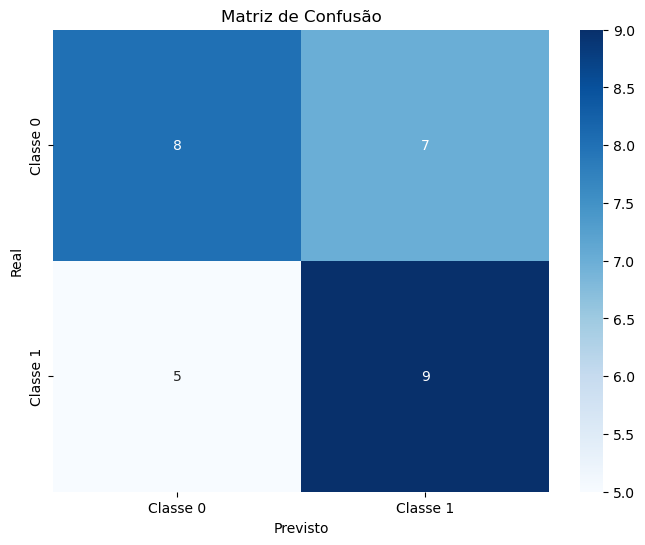

In [77]:
y_pred = decision_tree.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

## Teste com new_feature

In [78]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_new['data'], df_new['target'], test_size=0.2, random_state=42)

decision_tree = tree.DecisionTreeClassifier(max_depth=5)
decision_tree.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=5)

In [79]:
accuracy2 = decision_tree.score(X_test, y_test)
print("Accuracy:", accuracy2)

Accuracy: 0.6206896551724138


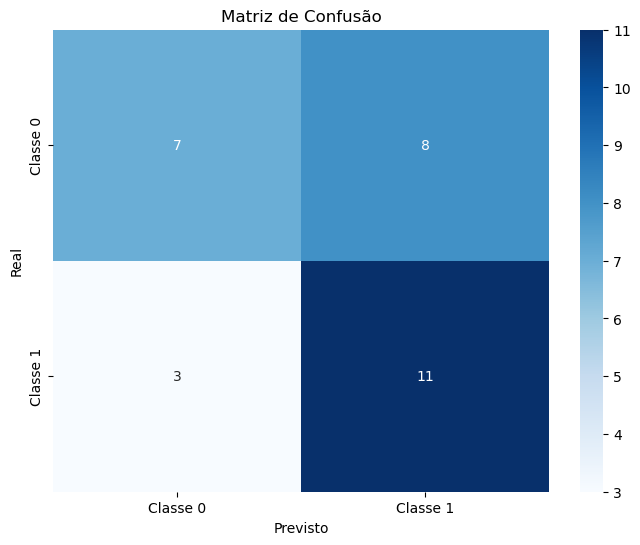

In [80]:
y_pred = decision_tree.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

## Comparação

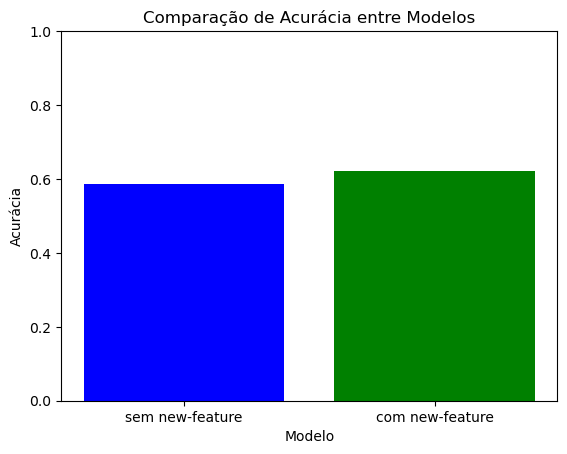

In [81]:
# Lista de modelos
modelos = ['sem new-feature', 'com new-feature']

# Lista de acurácias
acuracias = [accuracy1, accuracy2]

# Plotar o gráfico de barras
plt.bar(modelos, acuracias, color=['blue', 'green'])
plt.xlabel('Modelo')
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácia entre Modelos')
plt.ylim(0, 1)  # Limitar o eixo y entre 0 e 1 (intervalo de acurácia)
plt.show()

# Rede Neural

## Teste sem new-feature

In [82]:
X_train, X_test, y_train, y_test = train_test_split(df['data'], df['target'], test_size=0.2, random_state=42)

In [83]:
model = MLPClassifier(hidden_layer_sizes=(64, 64), activation='relu', solver='lbfgs', max_iter=10000, random_state=42)
model.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(64, 64), max_iter=10000, random_state=42,
              solver='lbfgs')

In [84]:
val_predictions = model.predict(X_test)
accuracy1 = accuracy_score(y_test, val_predictions)
print("Validation Accuracy:", accuracy1)

Validation Accuracy: 0.5172413793103449


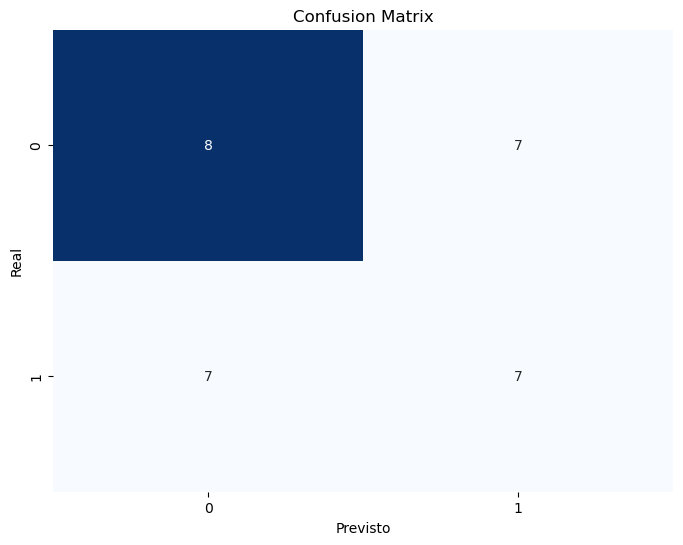

In [85]:
conf_matrix = confusion_matrix(y_test, val_predictions)

# Step 5: Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

## Teste com new_feature

In [86]:
X_train, X_test, y_train, y_test = train_test_split(df_new['data'], df_new['target'], test_size=0.2, random_state=42)

In [87]:
model = MLPClassifier(hidden_layer_sizes=(64, 64), activation='relu', solver='lbfgs', max_iter=10000, random_state=42)
model.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(64, 64), max_iter=10000, random_state=42,
              solver='lbfgs')

In [88]:
val_predictions = model.predict(X_test)
accuracy2 = accuracy_score(y_test, val_predictions)
print("Validation Accuracy:", accuracy2)

Validation Accuracy: 0.4827586206896552


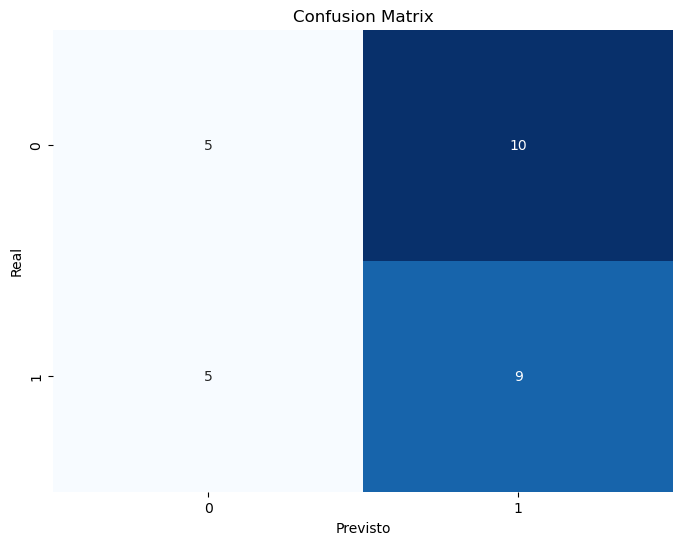

In [89]:
conf_matrix = confusion_matrix(y_test, val_predictions)

# Step 5: Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

## Comparação

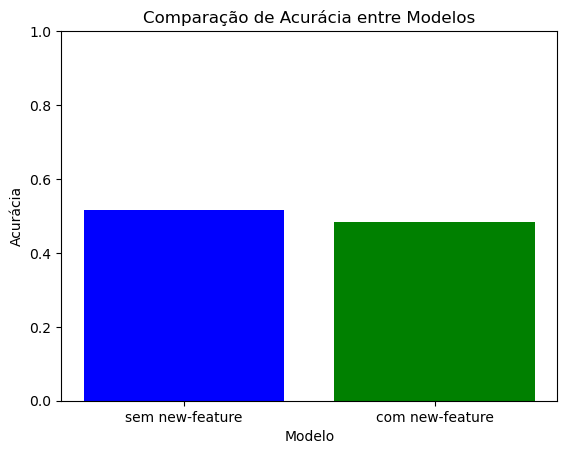

In [90]:
# Lista de modelos
modelos = ['sem new-feature', 'com new-feature']

# Lista de acurácias
acuracias = [accuracy1, accuracy2]

# Plotar o gráfico de barras
plt.bar(modelos, acuracias, color=['blue', 'green'])
plt.xlabel('Modelo')
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácia entre Modelos')
plt.ylim(0, 1)  # Limitar o eixo y entre 0 e 1 (intervalo de acurácia)
plt.show()

# Random Forest

## Teste sem new_feature

In [91]:
X_train, X_test, y_train, y_test = train_test_split(df['data'], df['target'], test_size=0.2, random_state=42)

In [92]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
val_predictions = model.predict(X_test)
accuracy1 = accuracy_score(y_test, val_predictions)
print("Validation Accuracy:", accuracy1)

Validation Accuracy: 0.5517241379310345


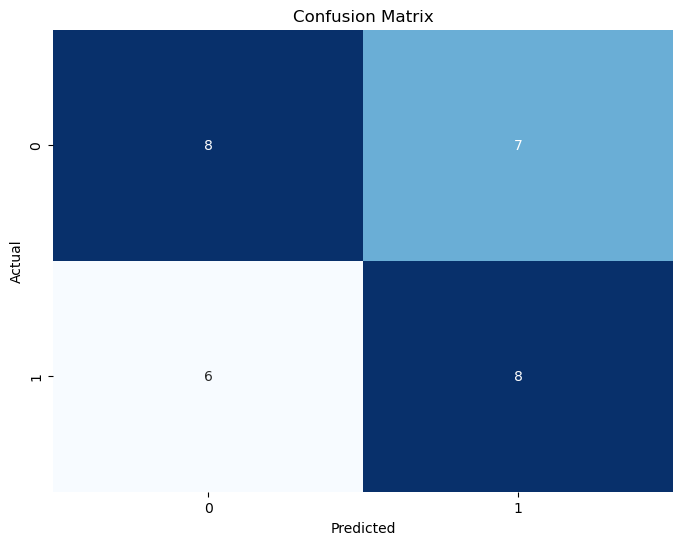

In [ ]:
conf_matrix = confusion_matrix(y_test, val_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Teste com new_feature

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_new['data'], df_new['target'], test_size=0.2, random_state=42)

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
val_predictions = model.predict(X_test)
accuracy2 = accuracy_score(y_test, val_predictions)
print("Validation Accuracy:", accuracy2)

Validation Accuracy: 0.5172413793103449


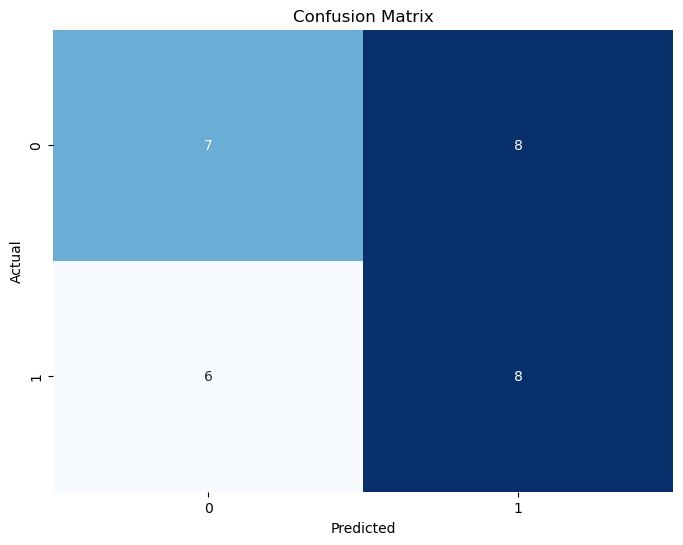

In [ ]:
conf_matrix = confusion_matrix(y_test, val_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Comparação

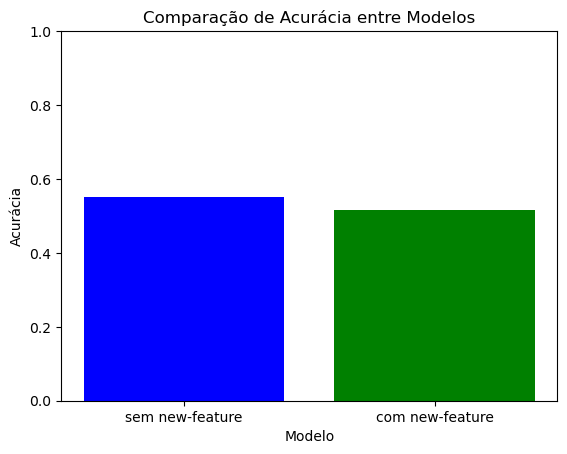

In [ ]:
# Lista de modelos
modelos = ['sem new-feature', 'com new-feature']

# Lista de acurácias
acuracias = [accuracy1, accuracy2]

# Plotar o gráfico de barras
plt.bar(modelos, acuracias, color=['blue', 'green'])
plt.xlabel('Modelo')
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácia entre Modelos')
plt.ylim(0, 1)  # Limitar o eixo y entre 0 e 1 (intervalo de acurácia)
plt.show()

# SVM

## Teste sem new_feature

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['data'], df['target'], test_size=0.2, random_state=42)

In [ ]:
model = SVC(kernel='rbf', random_state=42)
model.fit(X_train, y_train)

SVC(random_state=42)

In [ ]:
val_predictions = model.predict(X_test)
accuracy1 = accuracy_score(y_test, val_predictions)
print("Validation Accuracy:", accuracy1)

Validation Accuracy: 0.5172413793103449


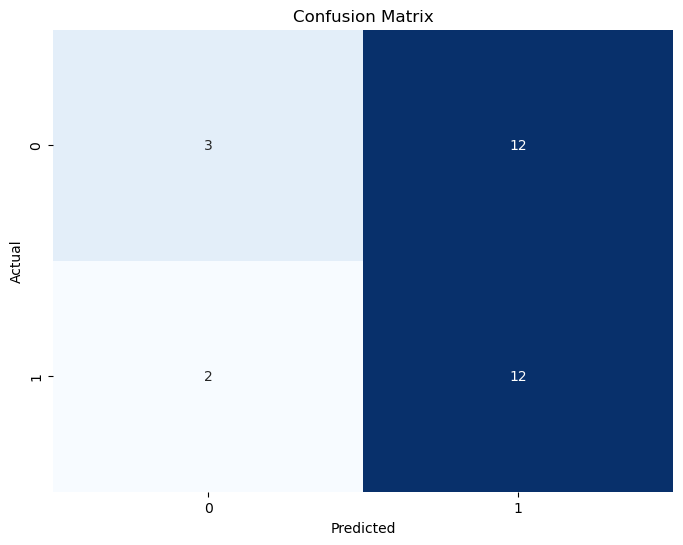

In [ ]:
conf_matrix = confusion_matrix(y_test, val_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Teste com new_feature

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_new['data'], df_new['target'], test_size=0.2, random_state=42)

In [ ]:
model = SVC(kernel='rbf', random_state=42)
model.fit(X_train, y_train)

SVC(random_state=42)

In [ ]:
val_predictions = model.predict(X_test)
accuracy2 = accuracy_score(y_test, val_predictions)
print("Validation Accuracy:", accuracy2)

Validation Accuracy: 0.6206896551724138


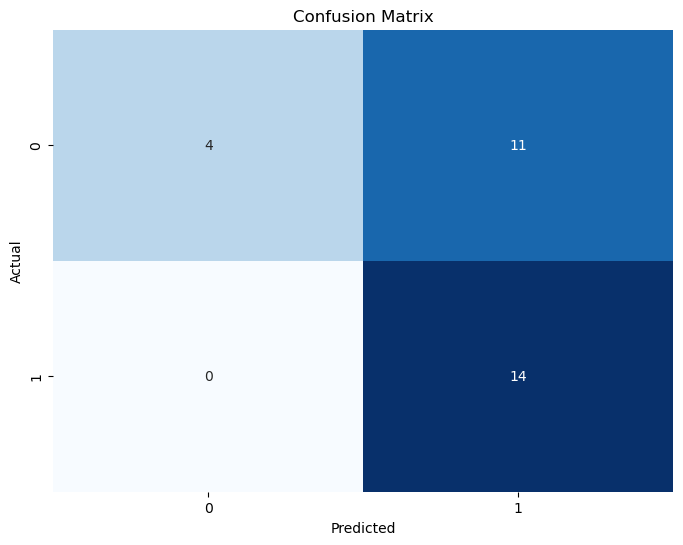

In [ ]:
conf_matrix = confusion_matrix(y_test, val_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Comparação

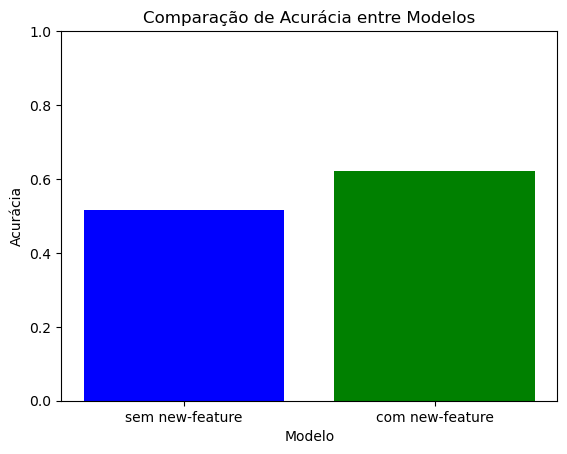

In [ ]:
# Lista de modelos
modelos = ['sem new-feature', 'com new-feature']

# Lista de acurácias
acuracias = [accuracy1, accuracy2]

# Plotar o gráfico de barras
plt.bar(modelos, acuracias, color=['blue', 'green'])
plt.xlabel('Modelo')
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácia entre Modelos')
plt.ylim(0, 1)  # Limitar o eixo y entre 0 e 1 (intervalo de acurácia)
plt.show()

# Logistic Regression

## Teste sem new_feature

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['data'], df['target'], test_size=0.2, random_state=42)

In [ ]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
val_predictions = model.predict(X_test)
accuracy1 = accuracy_score(y_test, val_predictions)
print("Validation Accuracy:", accuracy1)

Validation Accuracy: 0.5517241379310345


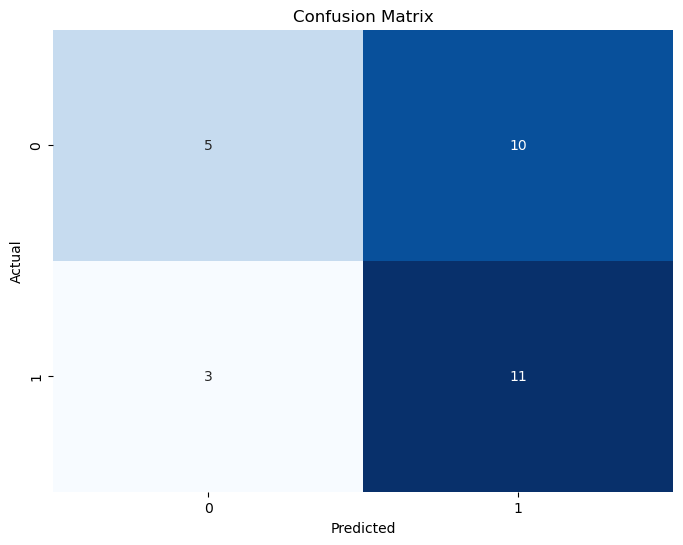

In [ ]:
conf_matrix = confusion_matrix(y_test, val_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Teste com new_feature

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_new['data'], df_new['target'], test_size=0.2, random_state=42)

In [ ]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
val_predictions = model.predict(X_test)
accuracy2 = accuracy_score(y_test, val_predictions)
print("Validation Accuracy:", accuracy2)

Validation Accuracy: 0.5517241379310345


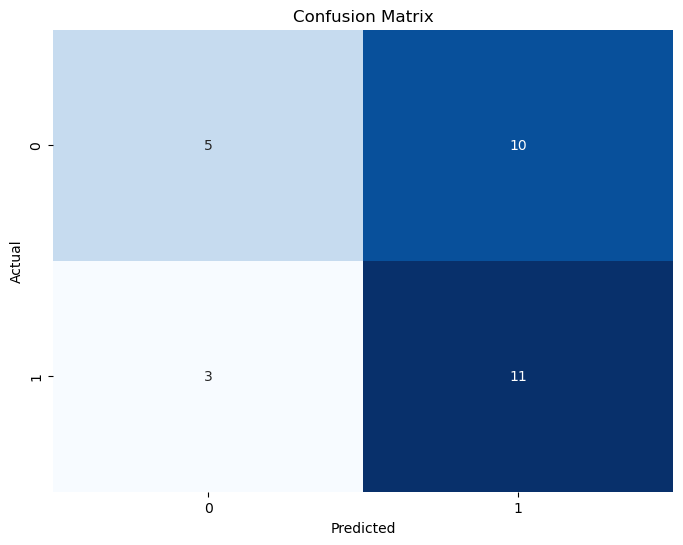

In [ ]:
conf_matrix = confusion_matrix(y_test, val_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Comparação

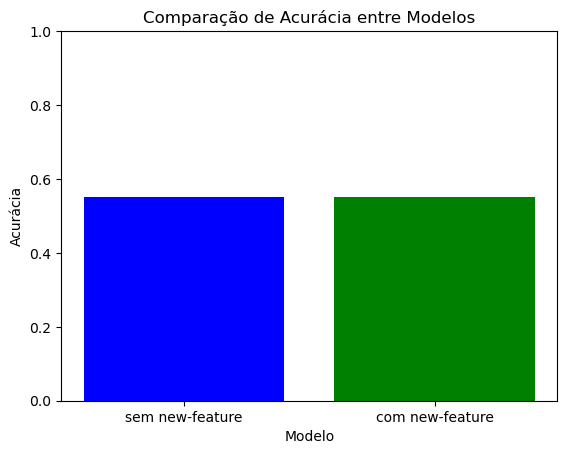

In [ ]:
# Lista de modelos
modelos = ['sem new-feature', 'com new-feature']

# Lista de acurácias
acuracias = [accuracy1, accuracy2]

# Plotar o gráfico de barras
plt.bar(modelos, acuracias, color=['blue', 'green'])
plt.xlabel('Modelo')
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácia entre Modelos')
plt.ylim(0, 1)  # Limitar o eixo y entre 0 e 1 (intervalo de acurácia)
plt.show()

# XGBoost

## Teste new_feature

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['data'], df['target'], test_size=0.2, random_state=42)

In [ ]:
model = xgb.XGBClassifier(random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [ ]:
val_predictions = model.predict(X_test)
accuracy1 = accuracy_score(y_test, val_predictions)
print("Validation Accuracy:", accuracy1)

Validation Accuracy: 0.5517241379310345


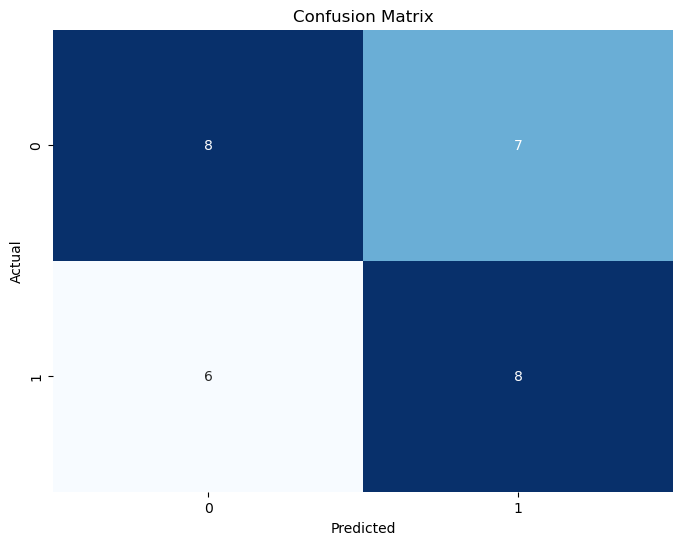

In [ ]:
conf_matrix = confusion_matrix(y_test, val_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Teste com new_feature

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_new['data'], df_new['target'], test_size=0.2, random_state=42)

In [ ]:
model = xgb.XGBClassifier(random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [ ]:
val_predictions = model.predict(X_test)
accuracy2 = accuracy_score(y_test, val_predictions)
print("Validation Accuracy:", accuracy2)

Validation Accuracy: 0.4482758620689655


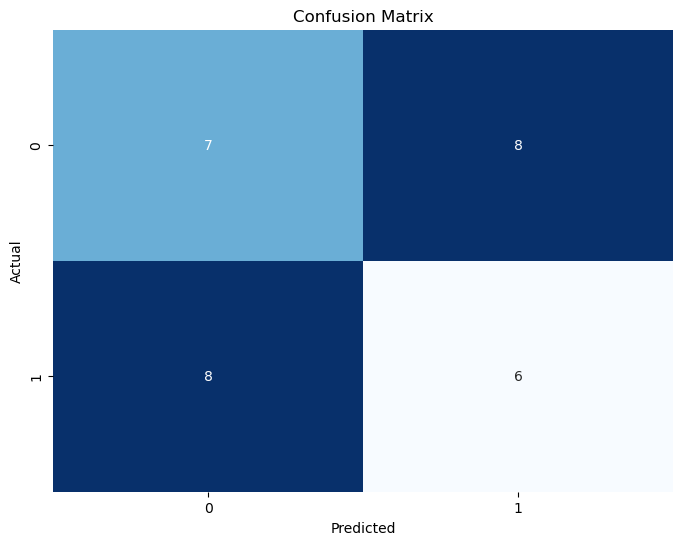

In [ ]:
conf_matrix = confusion_matrix(y_test, val_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Comparação

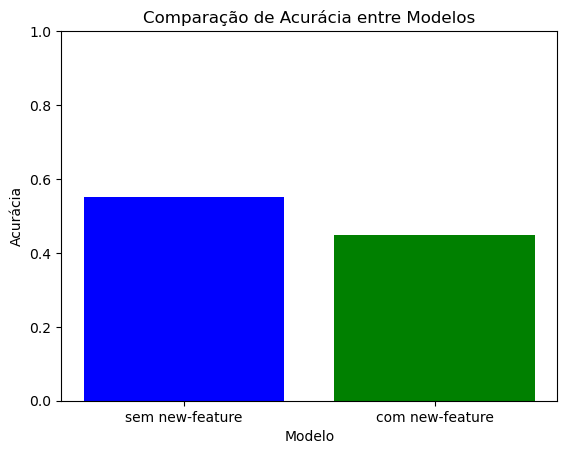

In [ ]:
# Lista de modelos
modelos = ['sem new-feature', 'com new-feature']

# Lista de acurácias
acuracias = [accuracy1, accuracy2]

# Plotar o gráfico de barras
plt.bar(modelos, acuracias, color=['blue', 'green'])
plt.xlabel('Modelo')
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácia entre Modelos')
plt.ylim(0, 1)  # Limitar o eixo y entre 0 e 1 (intervalo de acurácia)
plt.show()